In [90]:
import pandas as pd

In [91]:
customers_dataset = pd.read_csv('dataset/customers_dataset.csv')
geolocations_dataset = pd.read_csv('dataset/geolocation_dataset.csv')
order_items_dataset = pd.read_csv('dataset/order_items_dataset.csv')
order_payments_dataset = pd.read_csv('dataset/order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv('dataset/order_reviews_dataset.csv')
orders_dataset = pd.read_csv('dataset/orders_dataset.csv')
products_dataset = pd.read_csv('dataset/products_dataset.csv')
sellers_dataset = pd.read_csv('dataset/sellers_dataset.csv')
product_category_name_translation_dataset = pd.read_csv('dataset/product_category_name_translation.csv')

In [92]:
delivered_orders = orders_dataset[orders_dataset['order_status'] == 'delivered']

delivered_orders_with_payments_and_customers = delivered_orders.merge(
    order_payments_dataset,
    on='order_id',
    how='left',
).merge(
    customers_dataset,
    on='customer_id',
    how='left',
)


sales_by_region = (
    delivered_orders_with_payments_and_customers.groupby('customer_state')['payment_value']
    .sum()
    .reset_index()
    .sort_values(
        by='payment_value',
        ascending=False,
    )
    .reset_index(drop=True)
)


sales_by_region[:5]


,customer_state,payment_value
0,SP,5770266.19
1,RJ,2055690.45
2,MG,1819277.61
3,RS,861802.40
4,PR,781919.55


In [93]:
# Average Customer Lifetime Value by State: How much a typical customer from each state spends on average
# Customer Count by State: How many customers you have in each state


# High-value customers (even if there aren't many of them)
# Large customer bases (even if they spend less individually)


customers_and_sales = (
    delivered_orders_with_payments_and_customers.groupby(['customer_state', 'customer_unique_id'])['payment_value']
    .sum()
    .reset_index()
    .rename(columns={'payment_value': 'customer_lifetime_value'})
)

customers_and_sales = (
    customers_and_sales.groupby('customer_state')
    .agg({'customer_lifetime_value': 'mean', 'customer_unique_id': 'count'})
    .reset_index()
    .rename(columns={'customer_lifetime_value': 'avg_customer_value', 'customer_unique_id': 'customer_count'})
    .sort_values(by='avg_customer_value', ascending=False)
    .reset_index(drop=True)
)

customers_and_sales[:5]

,customer_state,avg_customer_value,customer_count
0,PB,273.481448,504
1,AC,257.713816,76
2,RO,246.648052,231
3,AP,244.572879,66
4,AL,243.399974,387


In [121]:
# Failed order rate / category

product_order_status_mapping_data = (
    orders_dataset.merge(order_items_dataset, on='order_id', how='left')
    .merge(products_dataset, on='product_id', how='left')
    .merge(product_category_name_translation_dataset, on='product_category_name', how='left')
)


# Step 1: Add a column to classify orders as 'failed' or 'delivered'
product_order_status_mapping_data['is_failed'] = product_order_status_mapping_data['order_status'].isin(['unavailable', 'canceled']).astype(int)
product_order_status_mapping_data['is_delivered'] = (product_order_status_mapping_data['order_status'] == 'delivered').astype(int)

# Step 2: Group by product_category_name_english and sum the counts
product_delivery_data = product_order_status_mapping_data.groupby('product_category_name_english')[['is_failed', 'is_delivered']].sum().reset_index()

# Step 3: Calculate failed rate
product_delivery_data['failed_rate (%)'] = (product_delivery_data['is_failed'] / product_delivery_data['is_delivered']) * 100

# Handle cases where is_delivered = 0 (avoid division by zero)
product_delivery_data['failed_rate (%)'] = product_delivery_data['failed_rate (%)'].replace([float('inf')], -1)

product_delivery_data.loc[(product_delivery_data['is_delivered'] == 0) & (product_delivery_data['is_failed'] == 0), 'failed_rate (%)'] = 0
product_delivery_data.loc[(product_delivery_data['is_delivered'] == 0) & (product_delivery_data['is_failed'] > 0), 'failed_rate (%)'] = 100

# Sort by failed rate
product_delivery_data = product_delivery_data.sort_values(by='failed_rate (%)', ascending=False).reset_index(drop=True)

product_delivery_data[:5]

,product_category_name_english,is_failed,is_delivered,failed_rate (%)
0,dvds_blu_ray,2,61,3.278689
1,construction_tools_safety,5,183,2.732240
2,diapers_and_hygiene,1,37,2.702703
3,costruction_tools_garden,4,232,1.724138
4,musical_instruments,11,651,1.689708


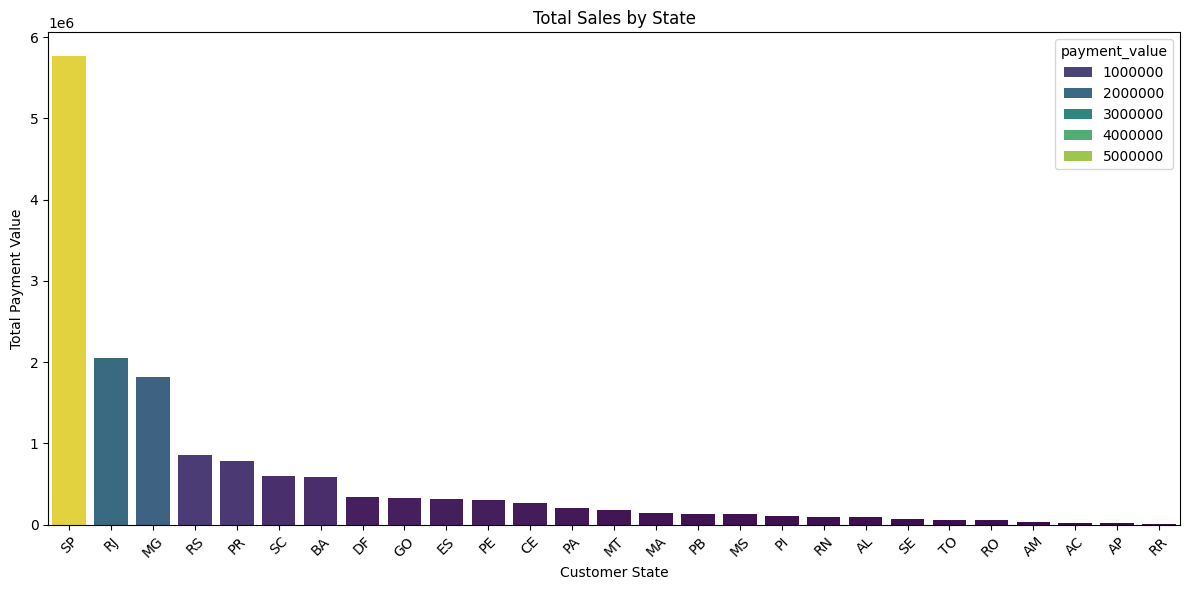

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=sales_by_region, x='customer_state', y='payment_value', hue='payment_value', palette='viridis')
plt.title('Total Sales by State')
plt.ylabel('Total Payment Value')
plt.xlabel('Customer State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


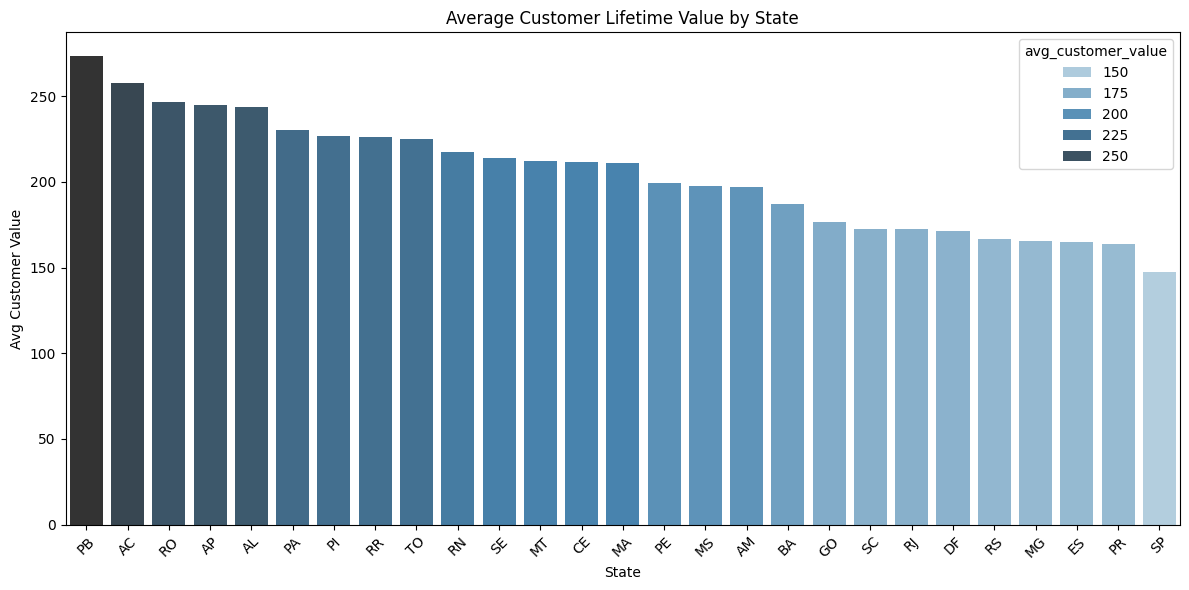

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=customers_and_sales, x='customer_state', y='avg_customer_value', hue='avg_customer_value', palette='Blues_d')
plt.title('Average Customer Lifetime Value by State')
plt.ylabel('Avg Customer Value')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

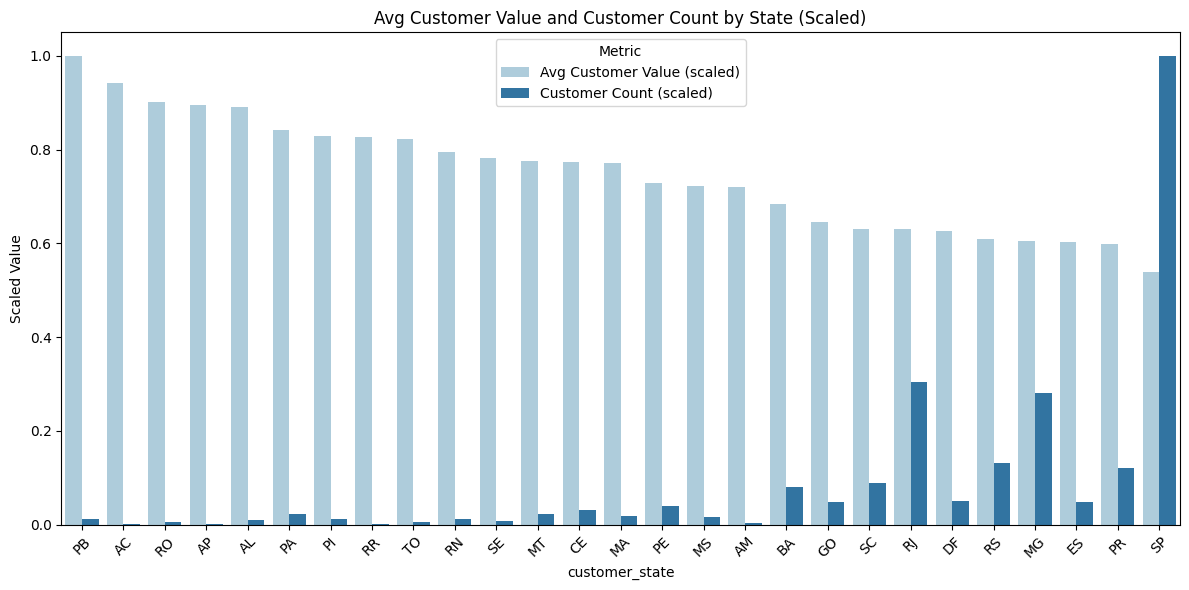

In [110]:
# Normalize
norm_data = customers_and_sales.copy()
norm_data['avg_customer_value_scaled'] = norm_data['avg_customer_value'] / norm_data['avg_customer_value'].max()
norm_data['customer_count_scaled'] = norm_data['customer_count'] / norm_data['customer_count'].max()

# Melt into long format for seaborn
melted = norm_data.melt(
    id_vars='customer_state', value_vars=['avg_customer_value_scaled', 'customer_count_scaled'], var_name='Metric', value_name='Scaled Value'
)

# Rename for prettier legend
melted['Metric'] = melted['Metric'].map(
    {'avg_customer_value_scaled': 'Avg Customer Value (scaled)', 'customer_count_scaled': 'Customer Count (scaled)'}
)

plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='customer_state', y='Scaled Value', hue='Metric', palette='Paired')
plt.title('Avg Customer Value and Customer Count by State (Scaled)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


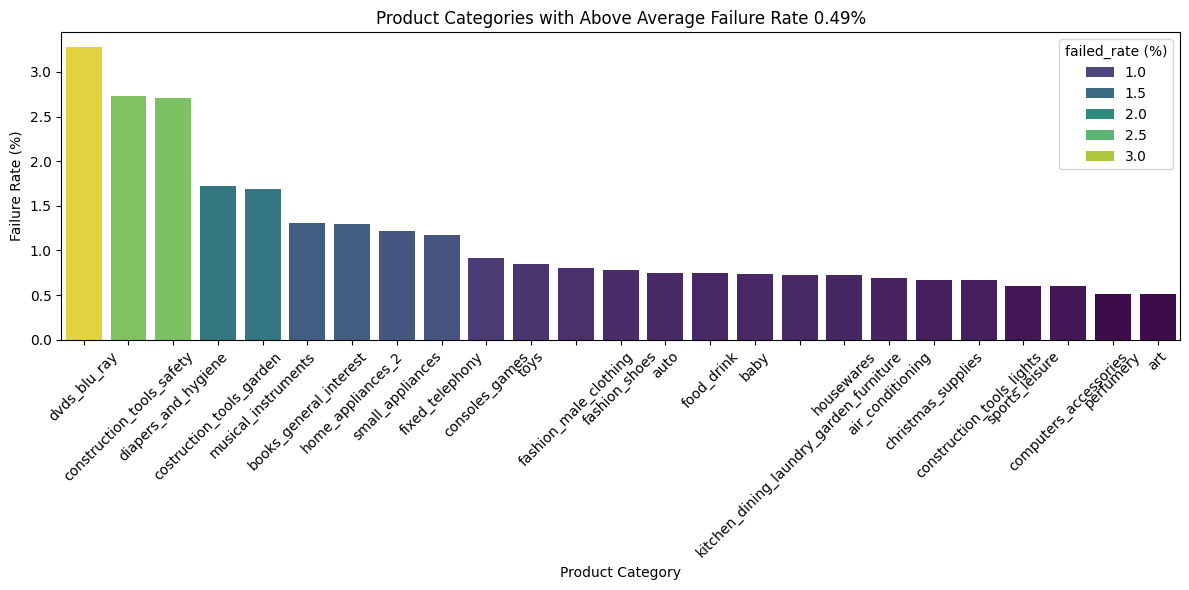

In [ ]:
average_failure_rate = product_delivery_data['failed_rate (%)'].mean()


# print(average_failure_rate)
above_avg_failure_categories = product_delivery_data[product_delivery_data['failed_rate (%)'] > average_failure_rate]


plt.figure(figsize=(12, 6))
sns.barplot(
    data=above_avg_failure_categories,
    x='product_category_name_english',
    y='failed_rate (%)',
    hue='failed_rate (%)',
    palette='viridis',
    legend=True,
)
plt.title(f'Product Categories with Above Average Failure Rate {average_failure_rate:.2f}%')
plt.ylabel('Failure Rate (%)')  # Corrected label
plt.xlabel('Product Category')  # Corrected label
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


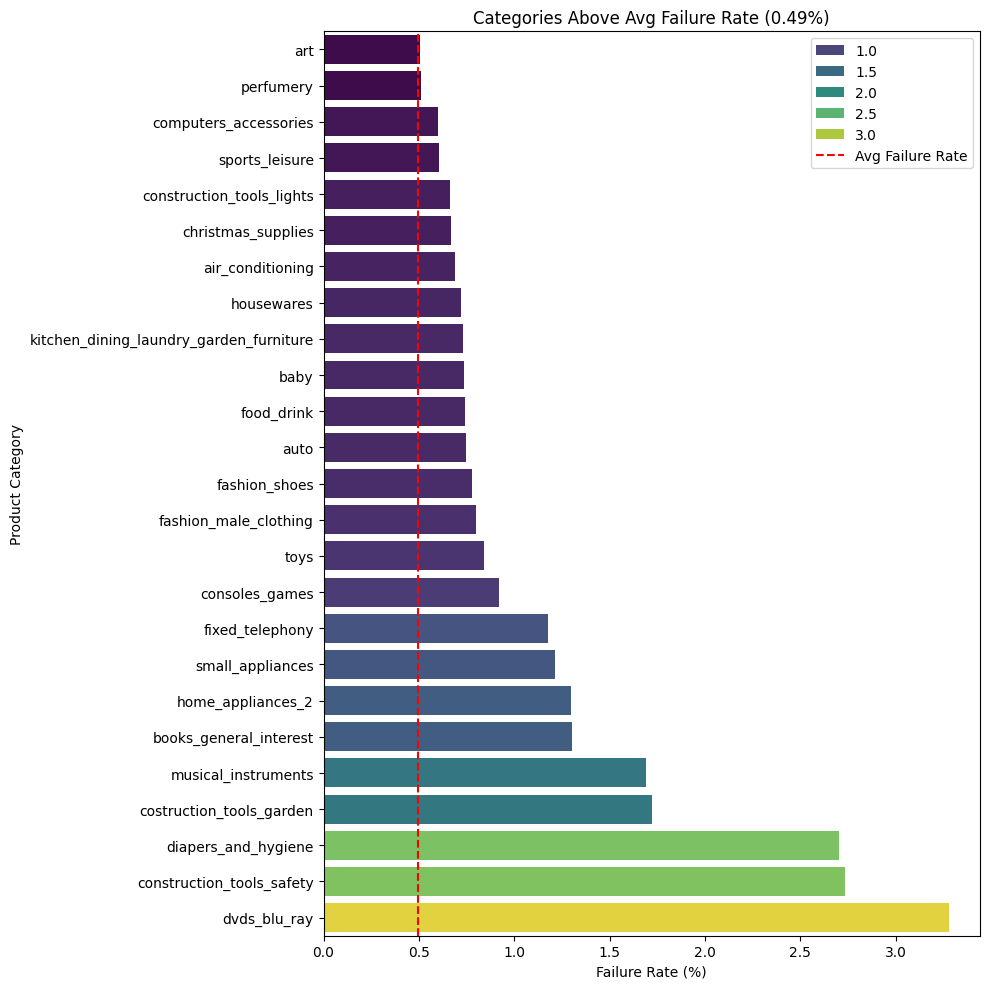

In [ ]:
plt.figure(figsize=(10, len(above_avg_failure_categories) * 0.4))
sns.barplot(
    data=above_avg_failure_categories.sort_values('failed_rate (%)'),
    x='failed_rate (%)',
    y='product_category_name_english',
    hue='failed_rate (%)',
    palette='viridis',
)
plt.axvline(average_failure_rate, color='red', linestyle='--', label='Avg Failure Rate')
plt.title(f'Categories Above Avg Failure Rate ({average_failure_rate:.2f}%)')
plt.xlabel('Failure Rate (%)')
plt.ylabel('Product Category')
plt.legend()
plt.tight_layout()
plt.show()
